In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. For simplicity's sake, we'll keep everything 1D for now. 

$$
    I(\alpha |\, \boldsymbol{\beta}) = a \exp \left [ -  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
    V(u |\, \boldsymbol{\beta}) = a e^{- 2 \pi \imath \delta_\alpha u^\prime} \exp \left [ -2 \sigma_\alpha^2 u^{\prime 2} \right ].
$$

Let's implement this sky plane model 

In [4]:
def sky_plane(alpha, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return a * np.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

In [3]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

Text(0, 0.5, '$I$')

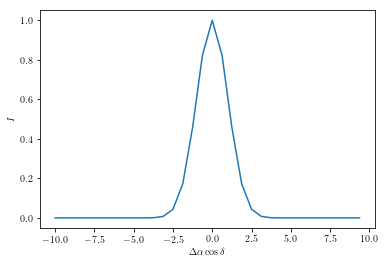

In [7]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
img_radius = 10.0 * arcsec


# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = np.empty(N_alpha, np.float)

for i,alpha in enumerate(ras):
    ys[i] = sky_plane(alpha)

plt.plot(ras/arcsec, ys)
plt.xlabel(r"$\Delta \alpha \cos \delta$")
plt.ylabel(r"$I$")

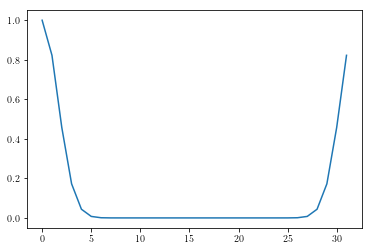

In [9]:
plt.plot(np.fft.fftshift(ys))

In [13]:
vis = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(ys)))
freqs = np.fft.ifftshift(np.fft.fftfreq(N_alpha, img_radius/(N_alpha)))

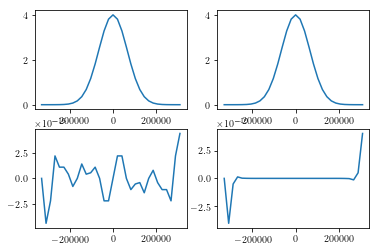

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[1,0].plot(freqs, np.imag(vis))

ax[0,1].plot(freqs, np.abs(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))

In [20]:
noise = 0.1 # Jy

In [26]:
# create a dataset off of this, by adding noise to the real and imaginary parts
# i.e., we need two noise draws
data = vis + np.random.normal(loc=0, scale=noise, size=(N_alpha)) + \
    np.random.normal(loc=0, scale=noise, size=(N_alpha)) * 1.0j 

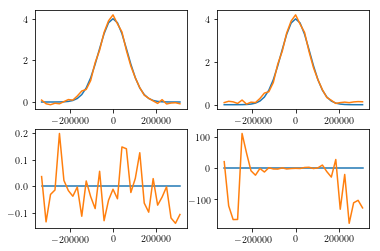

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[0,0].plot(freqs, np.real(data))

ax[1,0].plot(freqs, np.imag(vis))
ax[1,0].plot(freqs, np.imag(data))

ax[0,1].plot(freqs, np.abs(vis))
ax[0,1].plot(freqs, np.abs(data))

ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(data))

# Implementing this model in Theano

Now that we have a dataset, the challenging part is figuring out how to use PyMC3 and actually fit this with Theano. Let's start by implementing something `fft`ed with the Theano docs http://deeplearning.net/software/theano/library/tensor/fft.html to see if we have that part down

In [28]:
import theano
import theano.tensor as T
from theano.tensor import fft

x = T.matrix('x', dtype='float64')

rfft = fft.rfft(x, norm='ortho')
f_rfft = theano.function([x], rfft)

N = 1024
box = np.zeros((1, N), dtype='float64')
box[:, N//2-10: N//2+10] = 1

out = f_rfft(box)
c_out = np.asarray(out[0, :, 0] + 1j*out[0, :, 1])
abs_out = abs(c_out)